# Number One: Mapping Basics (Mapping NYC Art Galleries)

You have two datasets:

* A shapefile of New York City neighborhoods, unzipped into `nynta_14d/`
* A csv of art galleries in New York City, called `galleries.csv`

We're going to create a visualization by plotting points for each art gallery on top of a map of neighborhoods.

## Part Zero: Importing what you need

Probably pandas, geopandas, a bit of matplotlib magic to make your graphics show up in the notebook, maybe some other stuff..

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

## Part One: Opening your datasets

**Open up both files!**

You want to end up with two **GeoDataFrames**, which are exactly like dataframes except they, of course, have some geography associated with them - a.k.a. `geometry`. Geopandas works nicely with shapefiles **but** when you're dealing with the csv there's a little extra work involved.

**MAKE SURE YOU SET THE GALLERY CRS TO `{'init': 'epsg:4326'}` - the [world geodetic system](https://en.wikipedia.org/wiki/World_Geodetic_System).** The geopandas website wants you to use a different one - `3395` - but I promise it doesn't really work.

In [11]:
nynta = gpd.read_file('nynta_14d/nynta.shp')

In [12]:
df_galeries = pd.read_csv('galleries.csv')
points = df_galeries.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
galleries = gpd.GeoDataFrame(df_galeries, geometry=points)
galleries.crs = {'init': 'epsg:4326'}

In [13]:
galleries.head()

,name,tel,url,addr1,addr2,city,zip,longitude,latitude,geometry
0,O'reilly William & Co Ltd,(212) 396-1822,http://www.nyc.com/arts__attractions/oreilly_w...,52 E 76th St,NaN,New York,10021,-73.962731,40.773801,POINT (-73.96273075000001 40.77380087)
1,Organization of Independent Artists - Gallery 402,(212) 219-9213,http://www.nonprofitgallery.com/main/usa/ny/oi...,19 Hudson St.,NaN,New York,10013,-74.009386,40.716469,POINT (-74.00938579 40.71646851)
2,Owen Gallery,(212) 879-2415,http://www.owengallery.com/about-us,19 E 75th St,NaN,New York,10021,-73.964352,40.774001,POINT (-73.96435178 40.77400085)
3,P P O W Gallerie,(212) 647-1044,http://www.ppowgallery.com/,511 W 25th St,NaN,New York,10001,-74.003893,40.749585,POINT (-74.00389260999999 40.7495854)
4,P P O W Inc,(212) 941-8642,http://www.nyc.com/arts__attractions/p_p_o_w_i...,476 Broome St,NaN,New York,10013,-74.001764,40.722907,POINT (-74.00176390000001 40.72290743)


## Part Two: Making some maps

### Part Two, Section A: Mapping individually

Make a map of neighborhoods, and a map of galleries. Make sure the shape of Manhattan kind of **looks kind of like Google Maps**. If not you need to change your crs/projection!

**For the neighborhoods map,** make each shape a light grey color, and the boundary lines between the neighborhoods white. It's relaxing and good for adding more things to!

**For the galleries map,** make them all the same color. I don't care what color it is, just make it a liiiitle transparent so you can maybe kind of tell if galleries are close to one another.

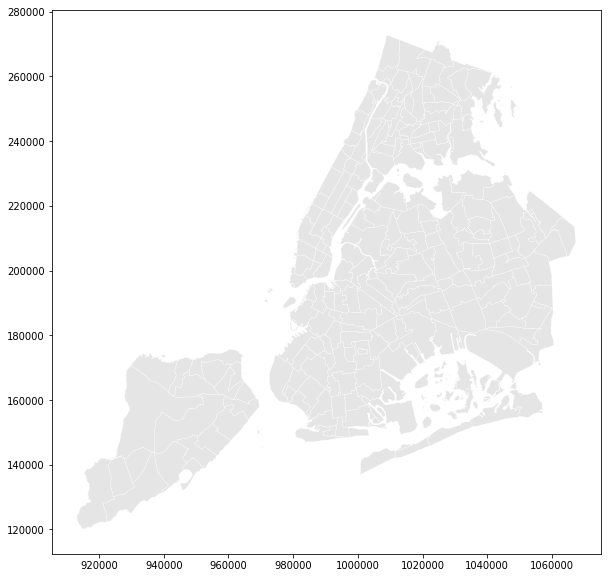

In [17]:
nynta.plot(
    figsize=(20,10),
    linewidth=0.25,
    edgecolor='white',
    color='#cccccc')

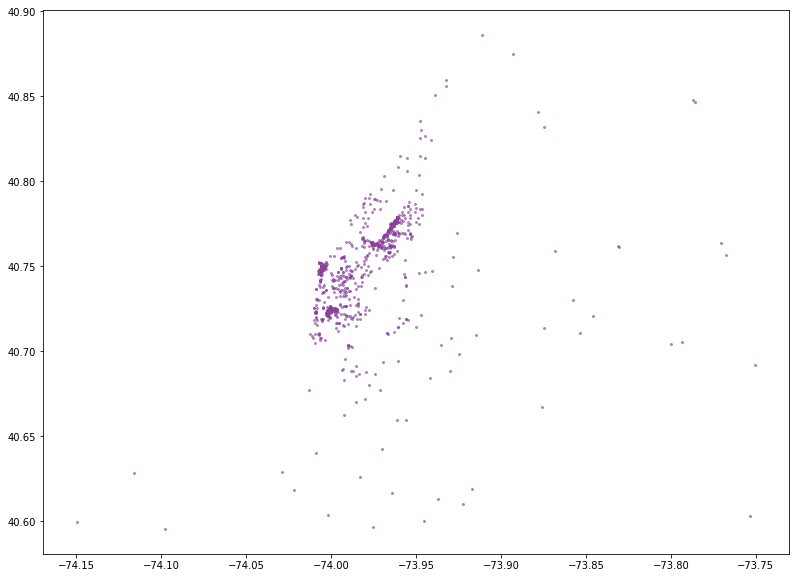

In [20]:
galleries.plot(
    figsize=(20,10),
    color='#88419d',
    markersize=2,
    alpha=0.55)

## Part Two, Section B: Map them on top of each other

Now make the map a *lot* bigger and plot the galleries on top of the neighborhoods.

And just so you know: you can't do it the easy way, it just won't work. I'm looking for a terrible failure here, not success.

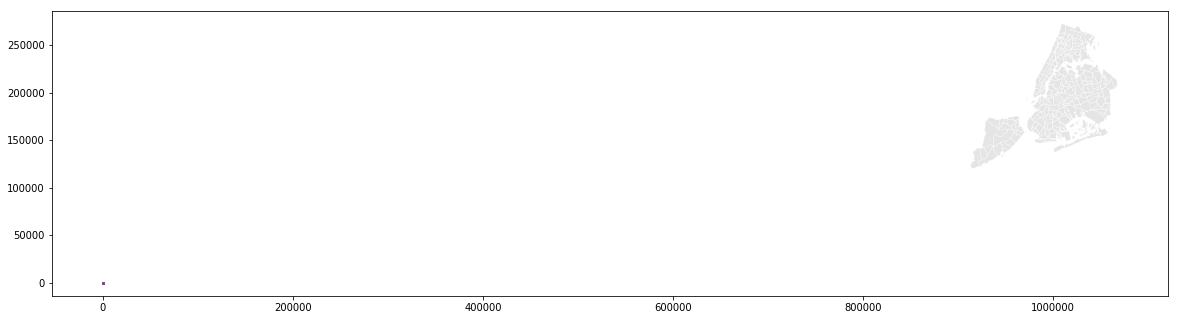

In [21]:
ax = nynta.plot(
    figsize=(20,10),
    linewidth=0.25,
    edgecolor='white',
    color='#cccccc')
galleries.plot(
    figsize=(20,10),
    color='#88419d',
    markersize=2,
    alpha=0.55,
    ax=ax)

Notice how the map is in the top right, and there's a little green in the bottom left? **That's a CRS problem.** Let's fix it.

### Let's fix any coordinate reference system (CRS) problems

The CRS is the coordinate system that's used to represent the globe, especially on a flat surface. Before you plot data, you need to make sure they're in the same CRS. If not, you wind up with problems like the above and you won't be able to put your datasets on the same map (or spatially join them, to boot).

**What's the CRS of the galleries?** Find out by running `galleries.crs`.

In [22]:
galleries.crs

{'init': 'epsg:4326'}

Yeah, we set that when we imported it. **What about the neighborhoods?** Is it the same CRS? Just do `.crs` on the neighborhoods geodataframe.

In [23]:
nynta.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

Hot damn, who even knows what that nonsense means! Well, I do, and technically speaking it's the [New York State Plane System](https://en.wikipedia.org/wiki/State_Plane_Coordinate_System). A lot of state- and city-level data will be state plane, and you aaalways need to convert it. It uses a potato shape and datum that's great for New York and not so great for places further away from New York.

And just as a reminder of how different the projects of the neighborhoods and galleries are, let's plot them both.

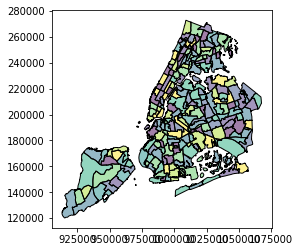

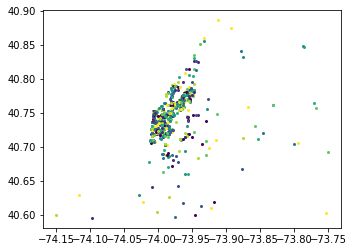

In [73]:
neighborhoods.plot()
galleries.plot()

**Notice how the neighborhoods axes are in the thousands, while ones for the galleries look like normal lat/long!** As a result, mapping them on the same map will never work.

For the New York State Plane System, basically what the government did was say "Screw latitude and longitude, let's put 0,0 at some point in New Jersey, and measure everything starting from there." So the big numbers on the NYC scale are *meters from some place in Jersey*.

**Okay, now let's convert the neighborhoods dataset to use the same CRS as the galleries dataset.**

In [25]:
nynta = nynta.to_crs(galleries.crs)
nynta.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...
2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380261 40.86170058826306...
3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...
4,3,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,POLYGON ((-73.90855790522767 40.65209593779451...


 See how the `geometry` now looks like latitude and longitude? Beautiful.
 
### Map the converted neighborhoods dataset with the galleries dataset

Everything should be good to go now. Make it look nice - enlarge it a bit, turn off the axes, make the neighborhoods pleasant and grey with white lines, and gentle up the gallery dots.

*And make sure you make the projection look like Google Maps!* It's the worst projection but hey it's fine for now! You can try `aea` if you wanna get crazy.

(-74.283370478149223,
 -73.672229948213371,
 40.47514452610185,
 40.936503645568806)

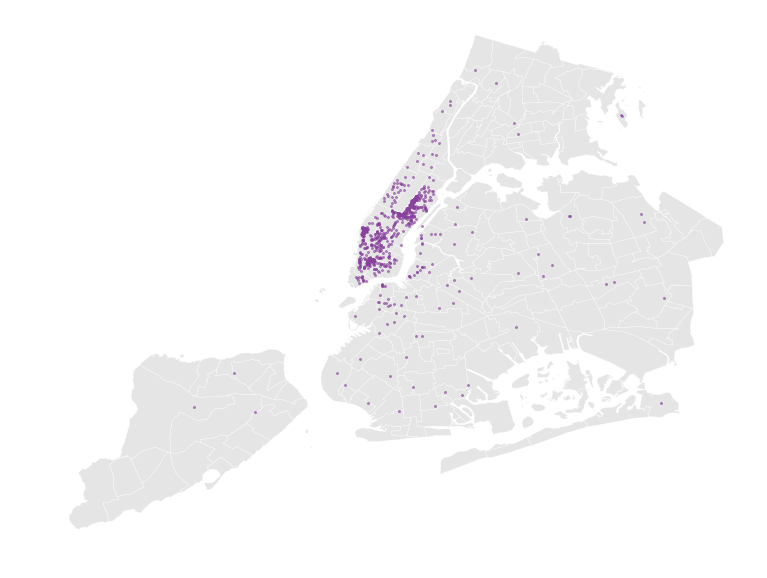

In [28]:
ax = nynta.plot(
    figsize=(20,10),
    linewidth=0.25,
    edgecolor='white',
    color='#cccccc')
galleries.plot(
    color='#88419d',
    markersize=2,
    alpha=0.55,
    ax=ax)
ax.axis('off')